<a href="https://colab.research.google.com/github/Ifedaniel/Analyzing-and-Forecasting-Temperature-Variations-with-the-ARIMA-Model/blob/main/ARIMA_(Autoregressive_Integrated_Moving_Average)_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Initial Setup**

1. First, you will setup your CoLab environment.

2. Then, you will authenticate a Google Drive client to download the file we will be processing in our Spark job.
Make sure to follow the interactive instructions.

3. Then, you will download the dataset `GlobalLandTemperatureByCountry.csv` and store it in your drive.
Check the panel in your left to note if the dataset has downloaded correctly under the "Files" tab.

In [1]:
!pip install prophet
!pip install pyspark
!pip install pyarrow
!pip install -U -q PyDrive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=b36f02be7c6dd51846383add3abc405fa350022ee78f68a776b08f053d5dda8a
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
file_list = drive.ListFile({'q': "'1WEWMdTfmeKD-tFrXrOlTtFkKhnoL_fU6' in parents"}).GetList()
for f in file_list:
  print('title: %s, id: %s' % (f['title'], f['id']))

In [4]:
id='13bxB3TO8Q8yK3qxAQql_Sltm1npK7yZJ'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('GlobalLandTemperaturesByCountry.csv')

***Check whether your dataset was downloaded and stored correctly***

## **From this point onwards, you are supposed to do the coding yourself. Refer the Exercise Sheet to carry out your analysis**

1. Carry out time series analysis to explore the dataset to derive important or relevant information.

2. Develop models using ARIMA or Prophet to forecast future time periods.

# **Time Series Forcasting of Global Land Temperature using an ARIMA Model**

The objective of this study is to conduct a time series analysis and forecasting utilizing the ARIMA model. This model will be trained on a dataset spanning from 1900 to 2010. Subsequently, it will be employed to predict the monthly average temperatures for the period of 2012 to 2015.

## **Data Dictionary.**

The variables in the dataset are as follows:
- **dt:** It is the date of observation, with the format YYYY-MM-DD.
- **AverageTemperature:** Record of the average temperature in degrees Celsius for the specified day.

- **AverageTemperatureUncertainty:** It is the uncertainty interval surrounding the average temperature, indicating the possibility of variation in the recorded average temperature.

- **Country:** The nation name for which temperature data is available.


In [5]:
#Importing the required library
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, col, isnan, when, count, lit
from pyspark.sql.types import DateType
from pyspark.ml.feature import Imputer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## **Cleaning and Exploration of Data.**

In [6]:
# Initialize a SparkSession
spark = SparkSession.builder \
    .appName("BigDataCourseWork") \
    .getOrCreate()

In [7]:
# Load the dataset
file_location = "/content/GlobalLandTemperaturesByCountry.csv"
global_land_temp = spark.read.csv(file_location, header=True, inferSchema=True)


In [8]:
#preview the dataset

global_land_temp.show()

+----------+-------------------+-----------------------------+-------+
|        dt| AverageTemperature|AverageTemperatureUncertainty|Country|
+----------+-------------------+-----------------------------+-------+
|1743-11-01| 4.3839999999999995|                        2.294|  Åland|
|1743-12-01|               NULL|                         NULL|  Åland|
|1744-01-01|               NULL|                         NULL|  Åland|
|1744-02-01|               NULL|                         NULL|  Åland|
|1744-03-01|               NULL|                         NULL|  Åland|
|1744-04-01|               1.53|                         4.68|  Åland|
|1744-05-01|  6.702000000000001|                        1.789|  Åland|
|1744-06-01| 11.609000000000002|                        1.577|  Åland|
|1744-07-01|             15.342|                         1.41|  Åland|
|1744-08-01|               NULL|                         NULL|  Åland|
|1744-09-01|             11.702|                        1.517|  Åland|
|1744-

In [9]:
#Before we begin data cleaning and exploration,
#we must first filter the data for the nations and timeframes of interest.


#storing the filtered data in a different variable
nations = ['United Kingdom','United States','Brazil', 'Kenya', 'India']

#transferring the filtered data to a different variable
nation_df = global_land_temp.filter(
    col('Country').isin(nations) &
    (col('dt') >= to_date(lit('1900-01-01'))) &
    (col('dt') <= to_date(lit('2015-12-31')))
)

#checking the first 5 rows of the filtered data

nation_df.show()

+----------+------------------+-----------------------------+-------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|Country|
+----------+------------------+-----------------------------+-------+
|1900-01-01|            25.086|                        0.657| Brazil|
|1900-02-01|            25.259|                        0.573| Brazil|
|1900-03-01|            25.835|                        0.605| Brazil|
|1900-04-01|24.601999999999997|                        0.799| Brazil|
|1900-05-01|            24.393|                        1.133| Brazil|
|1900-06-01|            23.518|                        0.934| Brazil|
|1900-07-01|             23.81|           0.8740000000000001| Brazil|
|1900-08-01|            24.313|                        0.463| Brazil|
|1900-09-01|25.296999999999997|                        0.544| Brazil|
|1900-10-01|            25.799|                        0.517| Brazil|
|1900-11-01|             25.54|                        0.621| Brazil|
|1900-12-01|        

### **Cleaning of Data**

In [10]:
#Validating the datatype
nation_df.printSchema()

root
 |-- dt: date (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- Country: string (nullable = true)



In [11]:
#Changing the datatype of the'dt' column

nation_df= nation_df.withColumn('dt', to_date(col('dt'),'yyyy-MM'))

In [12]:
#Revalidating the datatype
nation_df.printSchema()

root
 |-- dt: date (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- Country: string (nullable = true)



In [13]:
#Pyspark DF to Pandas DF conversion

nation_df_pd = nation_df.toPandas()

In [14]:
#checking if our data has missing values

nation_df_pd.isnull().sum()

dt                               0
AverageTemperature               4
AverageTemperatureUncertainty    4
Country                          0
dtype: int64

We have four missing data in the AverageTemperature and AverageTemperatureUncertainty.

We will drop the rows with null values


In [15]:
#dropping all null values

nation_df_pd=nation_df_pd.dropna()

In [16]:
#confirming if our data has missing values

nation_df_pd.isnull().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          0
dtype: int64

In [17]:
#Updating the PySpark DataFrame
nation_df = spark.createDataFrame(nation_df_pd)

In [18]:
#Printing the schema
nation_df.printSchema()

root
 |-- dt: date (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- Country: string (nullable = true)



### **EXploratory Data Analysis**

In [19]:
#Summary statistics for the selected the nations

summary_stats = nation_df_pd['AverageTemperature'].describe()

#result
summary_stats

count    6821.000000
mean       18.203825
std         9.010766
min        -6.737000
25%        11.320000
50%        22.964000
75%        25.091000
max        31.329000
Name: AverageTemperature, dtype: float64

The following are the summary data for the average temperature in all selected nations between 1900 and 2015:

- After filtering, there are a total of 6,821 data points.
- The average temperature is roughly 18.20°C.
- The standard deviation is approximately 9.01°C, showing a wide temperature range.
- The lowest temperature recorded is -6.74°C, while the highest is 31.33°C.
- The 25th percentile temperature is 11.32°C, the median temperature is 22.96°C, and the 75th percentile temperature is 25.09°C.


### **Temperature Distribution by Nations.**

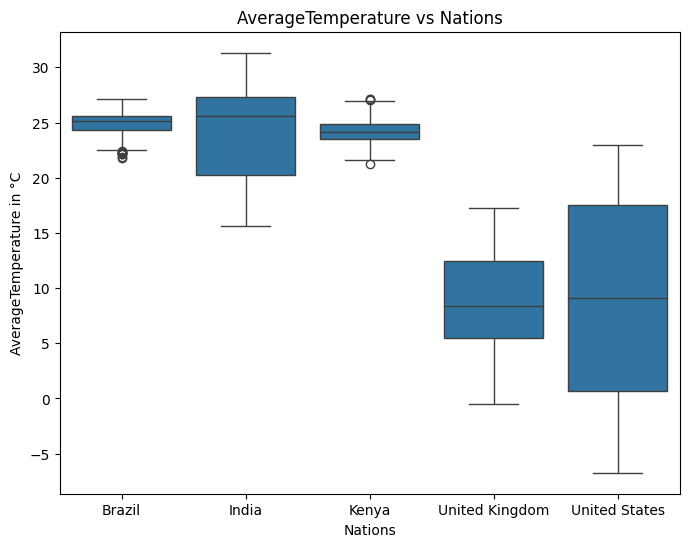

In [20]:
plt.figure(figsize=(8,6))

sns.boxplot(x='Country', y='AverageTemperature', data=nation_df_pd)

plt.title('AverageTemperature vs Nations')
plt.xlabel('Nations')
plt.ylabel('AverageTemperature in °C')

plt.show()

Only the United Kingdom and the United States have temperatures below zero, according to the visualisation. India has the highest average temperature of more than 30°C.


### **Average Temperature of each Nations**

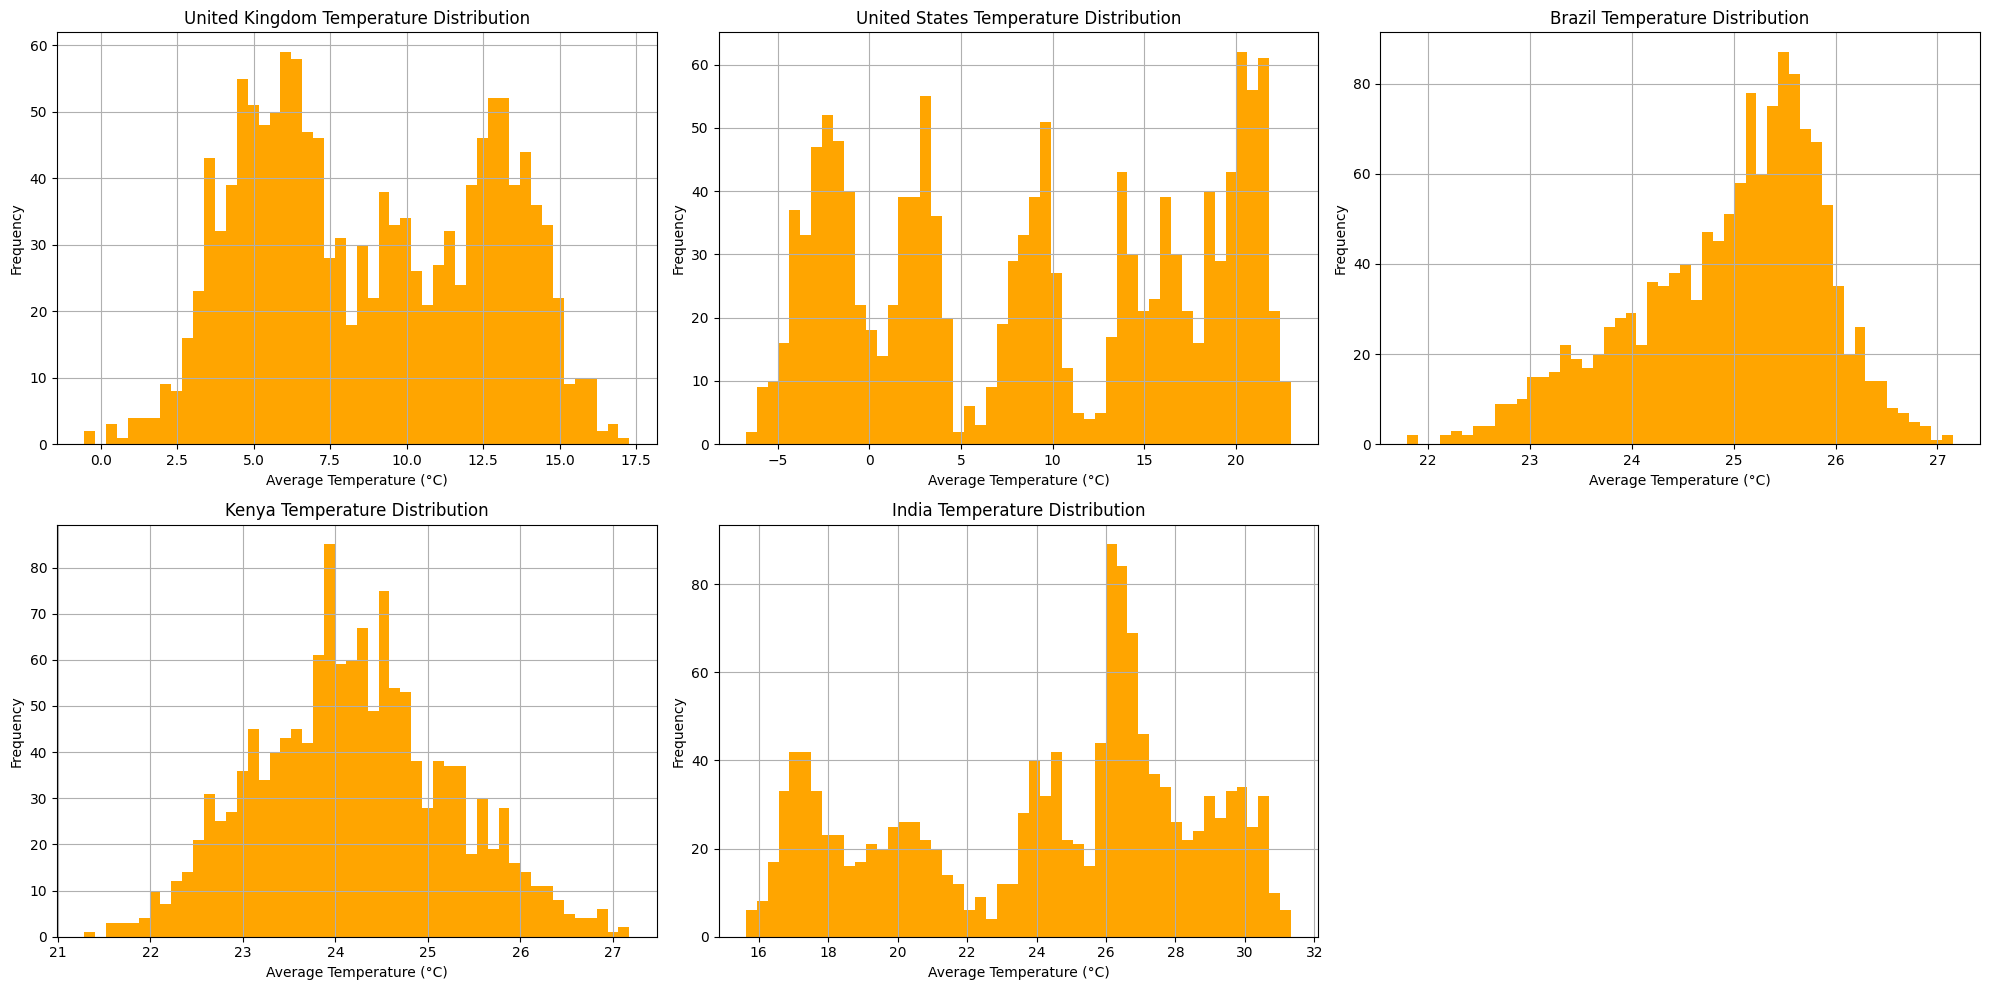

In [21]:
#The distribution of average temperatures for each nation of interest


plt.figure(figsize=(20,10))

for i, country in enumerate(nations, start=1):
  plt.subplot(2,3,i)
  subset = nation_df_pd[nation_df_pd['Country']==country]
  subset['AverageTemperature'].hist(bins=50, color='orange')
  plt.title(f'{country} Temperature Distribution')
  plt.xlabel('Average Temperature (°C)')
  plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



The histograms show the dispersion of average temperatures for each nations


In [22]:
nation_df_pd['dt'] = pd.to_datetime(nation_df_pd['dt'])

In [23]:
nation_df_pd['year'] = nation_df_pd['dt'].dt.year

In [24]:
nation_df_pd.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,year
0,1900-01-01,25.086,0.657,Brazil,1900
1,1900-02-01,25.259,0.573,Brazil,1900
2,1900-03-01,25.835,0.605,Brazil,1900
3,1900-04-01,24.602,0.799,Brazil,1900
4,1900-05-01,24.393,1.133,Brazil,1900


In [56]:
temp_data = nation_df_pd.groupby('year').agg({'AverageTemperature':'mean','AverageTemperatureUncertainty':'mean'}).reset_index()

#adding calculated temperature values
temp_data['max_temp'] = temp_data['AverageTemperature'] + temp_data['AverageTemperatureUncertainty']
temp_data['min_temp'] = temp_data['AverageTemperature'] - temp_data['AverageTemperatureUncertainty']

#checking the calculated columns
temp_data.head()

,year,AverageTemperature,AverageTemperatureUncertainty,max_temp,min_temp
0,1900,18.194900,0.591467,18.786367,17.603433
1,1901,18.005983,0.628033,18.634017,17.377950
2,1902,17.914667,0.537217,18.451883,17.377450
3,1903,17.736567,0.524617,18.261183,17.211950
4,1904,17.570317,0.554583,18.124900,17.015733


<Figure size 1600x1000 with 0 Axes>

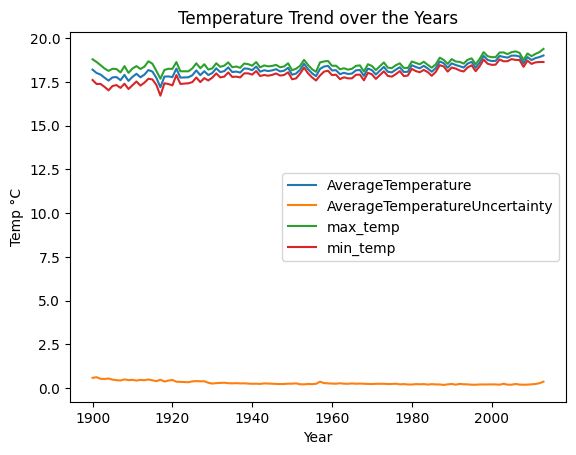

In [26]:
#Plotting Temperature trend over the Years

plt.figure(figsize=(16,10))

temp_data.plot(x='year', y=['AverageTemperature','AverageTemperatureUncertainty','max_temp','min_temp'])
plt.title('Temperature Trend over the Years')
plt.xlabel('Year')
plt.ylabel('Temp °C')

plt.show()

### **Trend of Average Temperature for each Nation.**

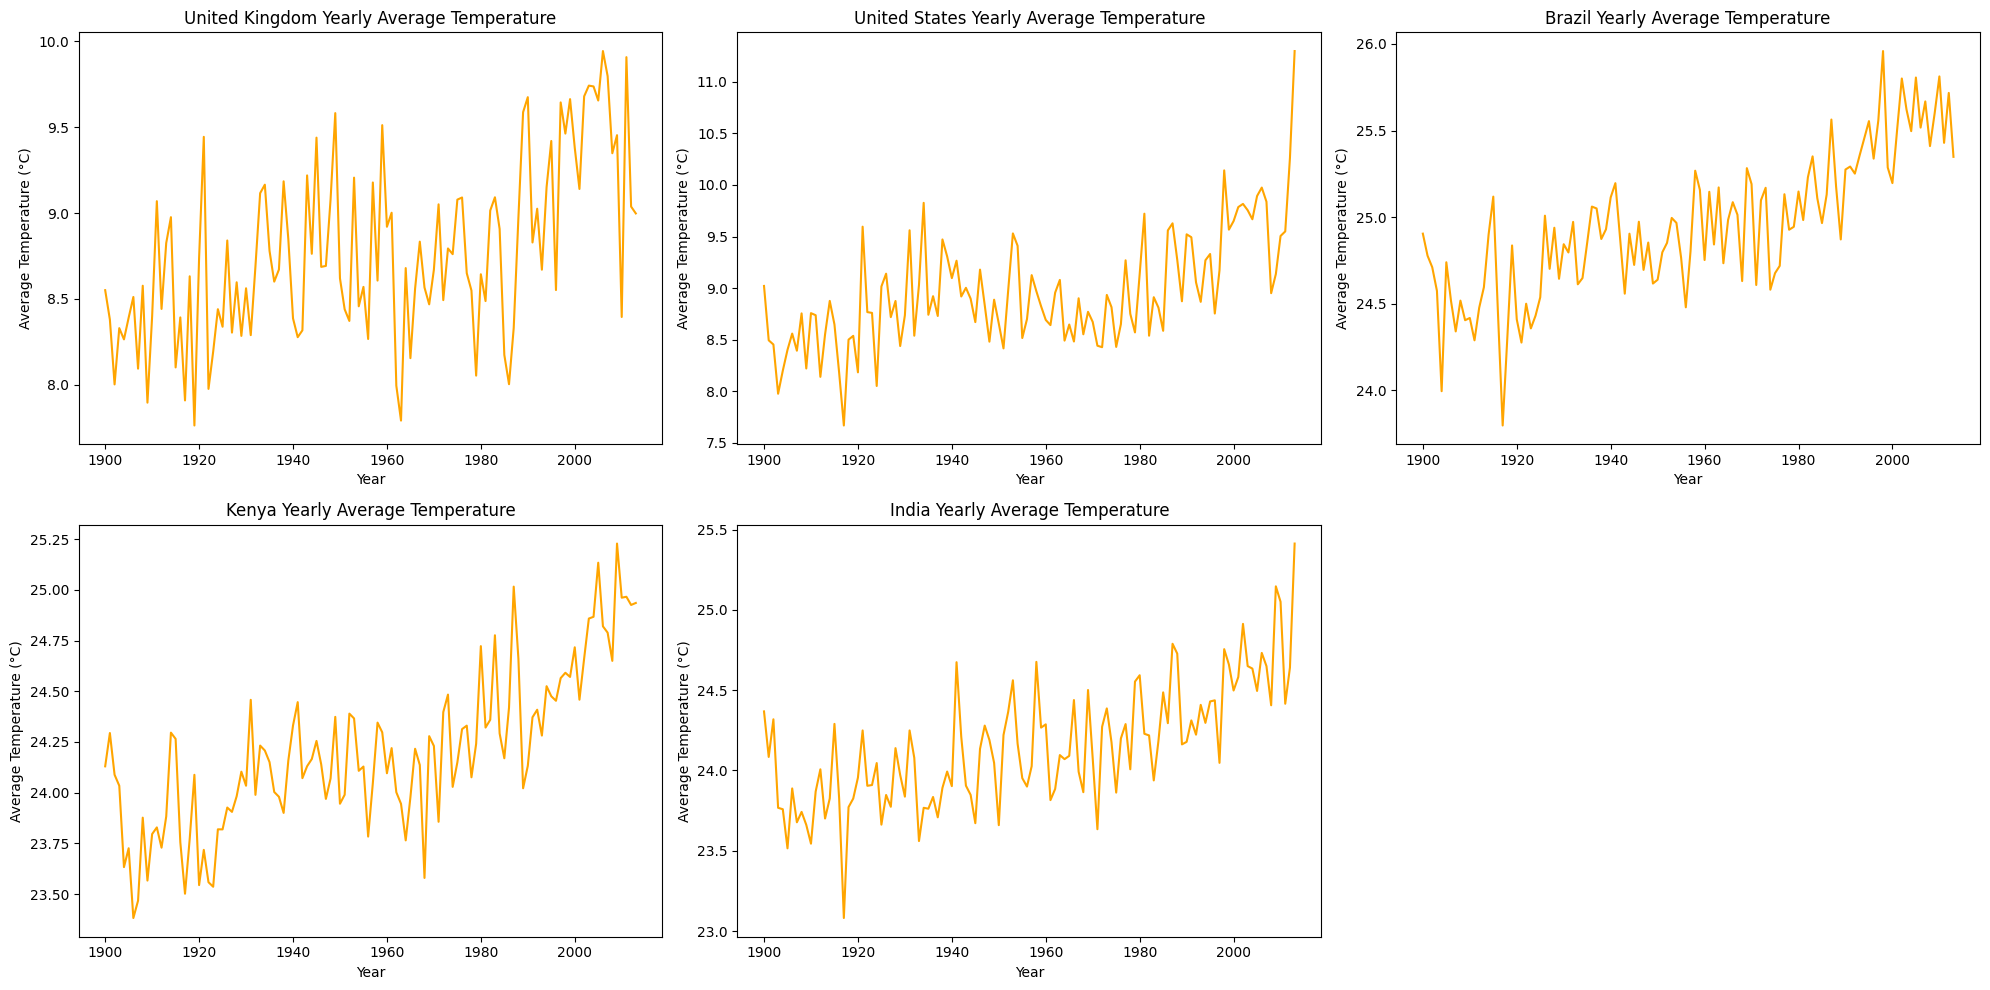

In [27]:
#each country's yearly average temperature trend

#Changing the datatype of the'dt' column

nation_df_pd['dt']= pd.to_datetime(nation_df_pd['dt'],format='%Y-%m')

plt.figure(figsize=(20,10))

for i, country in enumerate(nations, start = 1):
  plt.subplot(2,3,i)
  subset = nation_df_pd[nation_df_pd['Country']==country]
  yearly_temp = subset.groupby(subset['dt'].dt.year)['AverageTemperature'].mean()
  plt.plot(yearly_temp, color='orange')
  plt.title(f'{country} Yearly Average Temperature')
  plt.xlabel('Year')
  plt.ylabel('Average Temperature (°C)')

plt.tight_layout()
plt.show()

### **Time Series Decomposition**

Time Series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components

In [28]:
#Taking a look at our data

nation_df_pd.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country,year
0,1900-01-01,25.086,0.657,Brazil,1900
1,1900-02-01,25.259,0.573,Brazil,1900
2,1900-03-01,25.835,0.605,Brazil,1900
3,1900-04-01,24.602,0.799,Brazil,1900
4,1900-05-01,24.393,1.133,Brazil,1900


In [29]:
#Let's just extract the date and temperature

nation_temp_df = nation_df_pd[['dt','AverageTemperature']]

#previewing
nation_temp_df.head()

,dt,AverageTemperature
0,1900-01-01,25.086
1,1900-02-01,25.259
2,1900-03-01,25.835
3,1900-04-01,24.602
4,1900-05-01,24.393


In [30]:
#Rechecking the datatype

nation_temp_df.dtypes

dt                    datetime64[ns]
AverageTemperature           float64
dtype: object

We still have the correct datatype

In [31]:
#Checking for missing values

nation_temp_df.isnull().sum()

dt                    0
AverageTemperature    0
dtype: int64

We have no missing values

In [32]:
#We index the dataframe with the date column for in prepraption for the model
nation_temp_df.set_index('dt',inplace=True)

#checking
nation_temp_df.head()

,AverageTemperature
dt,
1900-01-01,25.086
1900-02-01,25.259
1900-03-01,25.835
1900-04-01,24.602
1900-05-01,24.393


In [33]:
#adding year

nation_temp_df['year']=nation_temp_df.index.year
nation_temp_df['month']=nation_temp_df.index.month

nation_temp_df.head()

,AverageTemperature,year,month
dt,,,
1900-01-01,25.086,1900,1
1900-02-01,25.259,1900,2
1900-03-01,25.835,1900,3
1900-04-01,24.602,1900,4
1900-05-01,24.393,1900,5


In [34]:
#pivoting the data
pivot=nation_temp_df.pivot_table(values='AverageTemperature',index='month', columns='year')

pivot

year,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
month,,,,,,,,,,,,,,,,,,,,,
1,13.6998,13.3222,13.5164,13.2638,12.6824,12.8278,13.2590,13.4018,13.2720,13.2314,...,14.0770,14.7472,14.8330,14.5938,14.0778,14.0746,13.4828,13.6228,14.1502,14.2620
2,14.0026,13.4946,13.9434,14.4132,13.6340,13.1544,14.0238,13.7786,14.5504,14.1462,...,15.1514,15.7028,15.7780,15.2372,14.8682,15.5908,14.9556,15.2562,15.4296,15.0524
3,16.5508,16.1366,16.7216,16.6974,15.9920,16.5040,15.4556,16.5774,16.2446,15.9760,...,18.0274,17.7276,16.8512,17.6082,17.0088,17.5402,17.7232,17.3538,18.1714,16.6482
4,18.6056,18.1258,18.3112,17.8440,18.2048,17.5902,18.1678,17.4894,18.3484,17.8034,...,19.5848,19.3514,19.1498,19.8010,18.5776,19.4358,19.7418,19.6092,19.2110,18.4428
5,20.3728,20.3696,20.2368,19.9658,19.9034,20.2620,20.2718,19.3928,20.3692,19.7520,...,21.1808,20.9606,20.9986,21.1928,20.9564,21.2848,21.1606,21.0468,21.2874,20.8812
6,21.7944,21.4130,21.4758,21.1254,20.8404,21.7220,21.0474,20.5794,21.3726,20.6654,...,21.8936,22.5268,22.2906,22.1424,21.4832,22.2346,22.5406,21.9728,22.1288,22.0290
7,22.0532,22.5404,21.4716,21.5024,21.3276,21.7340,21.2564,21.0158,21.5056,21.0274,...,22.1078,22.3120,23.0602,22.1594,22.2440,22.3664,22.4206,22.4370,22.4168,22.5762
8,21.5640,21.7952,21.2894,21.1136,21.1106,21.4132,21.4984,20.6804,20.9048,21.2764,...,22.1982,22.3918,22.2520,22.2842,22.1624,22.4372,22.2628,22.2788,22.5132,22.2990
9,20.7570,20.8906,20.4140,20.3024,20.3288,20.4794,20.6102,20.5756,20.4978,20.1050,...,21.5062,21.5968,21.5100,21.4760,21.2176,21.7584,21.4444,21.5704,21.3892,18.2730


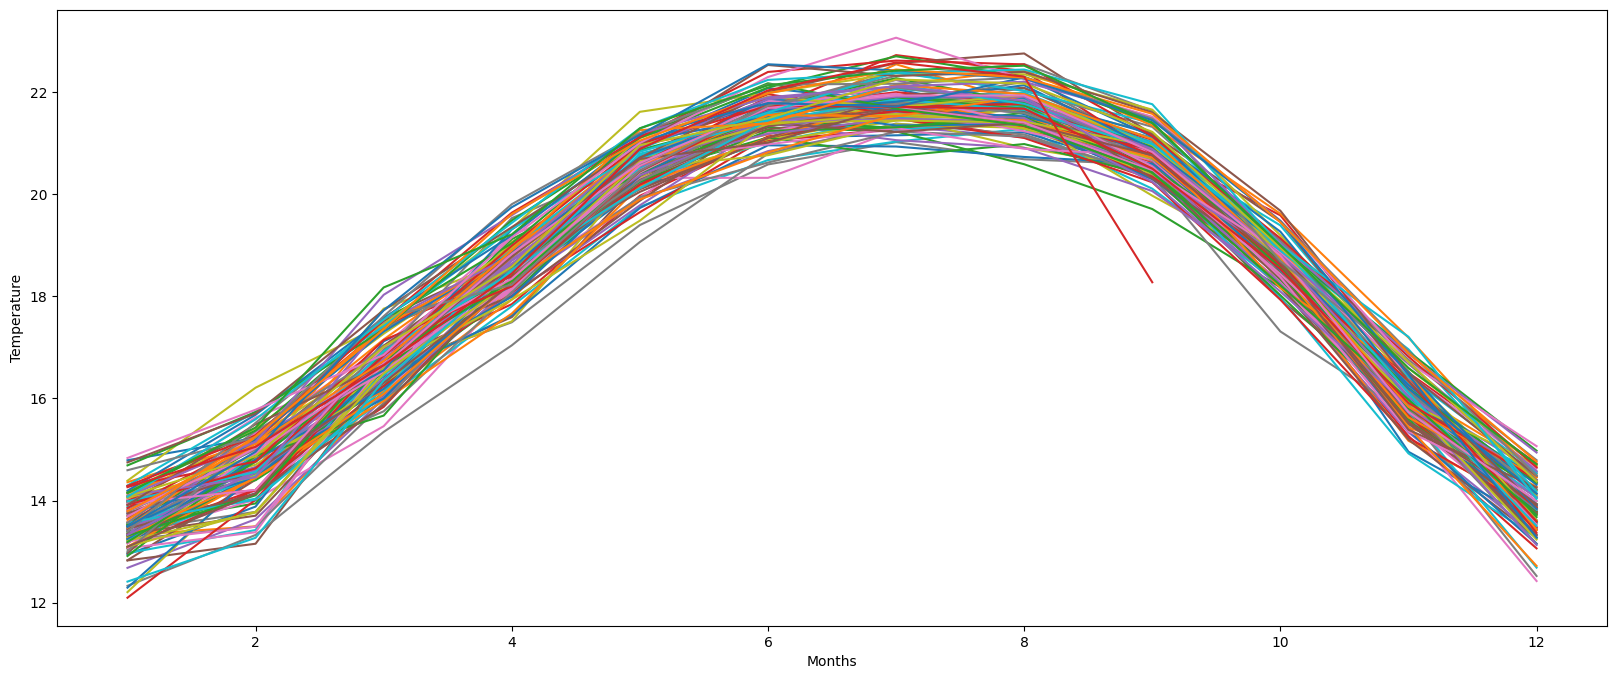

In [35]:
#ploting the pivot table
pivot.plot(figsize=(20,8))
plt.legend().remove()
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.show()

From here we can confirm that we have seasonality has the temperature for each year follows a trend.

After confirming that we have seasonality in our data, we can confirm that our data is not stationery, but we still have to make a test to confirm.

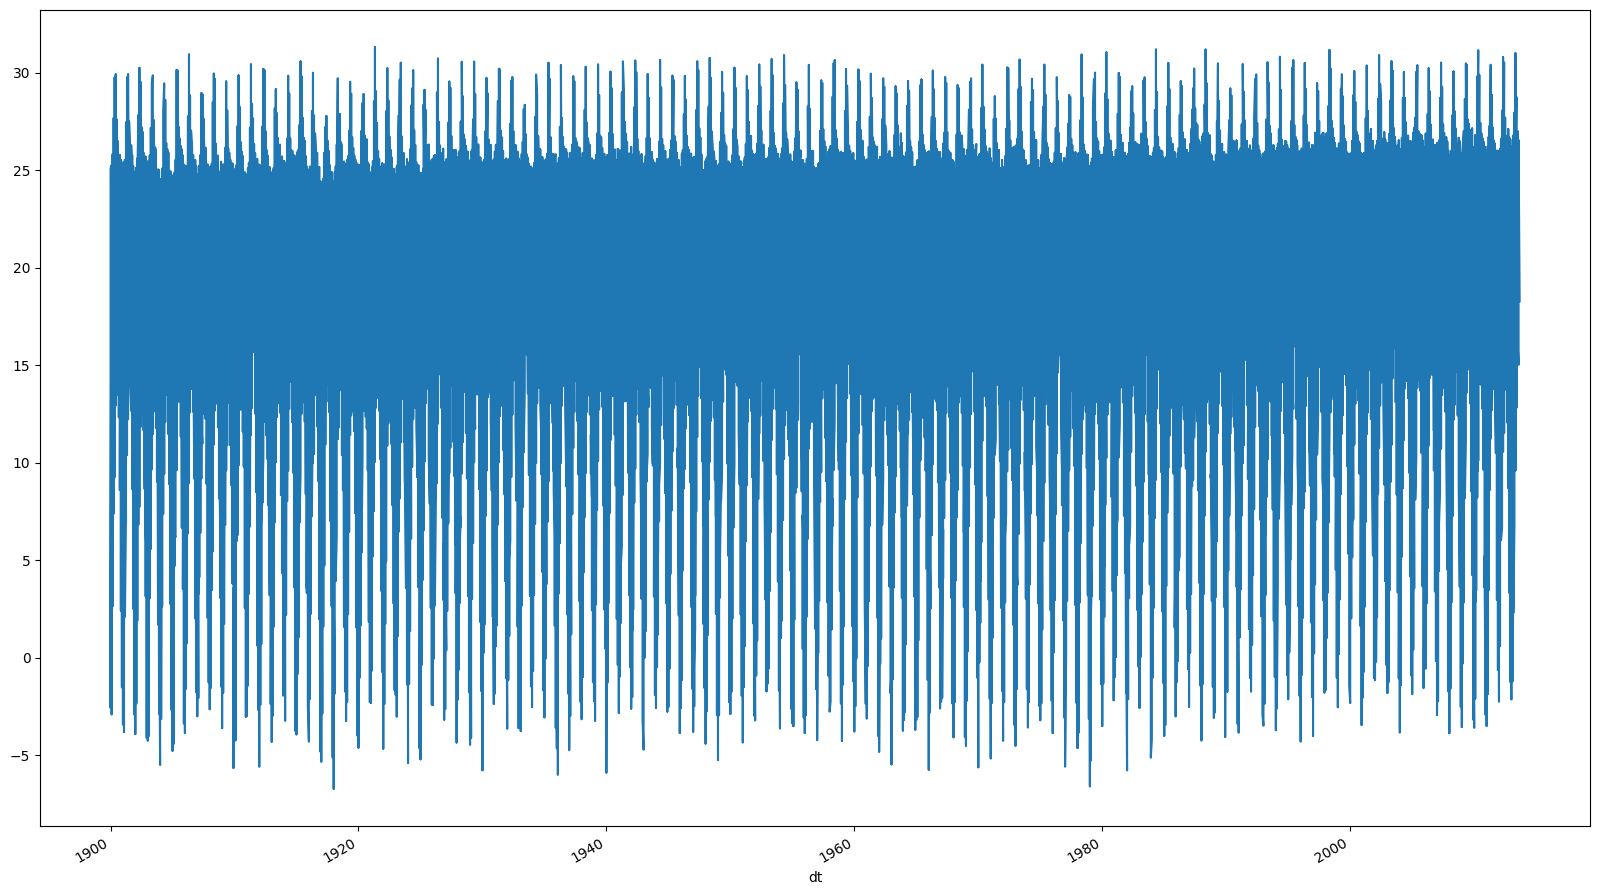

In [36]:
#ploting a line chart to confirm stationary
nation_temp_df['AverageTemperature'].plot(figsize=(20,12))
plt.show()

From the visualization above, seasonality is confirmed again

In [37]:
#Testing for Stationary using ADF

from statsmodels.tsa.stattools import adfuller


adfuller(nation_temp_df['AverageTemperature'])



(-0.9231599712482156,
 0.7802498665823668,
 35,
 6785,
 {'1%': -3.4313141526473365,
  '5%': -2.8619660758870054,
  '10%': -2.5669967964630027},
 18510.655519659093)

In [38]:
#Let define a function to the result of the test to make a mean out of it.

def adf_test(data):
  result=adfuller(data)
  labels=['ADF Test stats','p-value','lags_used','nobs']
  for value,label in zip(result,labels):
    print(label + ' : '+ str(value))
  if result[1] <=0.05:
    print('reject the Ho, data is stationary')
  else:
    print('fail to reject the Ho, data is not stationary')

In [39]:
adf_test(nation_temp_df['AverageTemperature'])

ADF Test stats : -0.9231599712482156
p-value : 0.7802498665823668
lags_used : 35
nobs : 6785
fail to reject the Ho, data is not stationary


In [40]:
#Making our data stationary

#To make our data stationary, we make use of 12shifts, since we are dealing with 12 periods

nation_temp_df['first_temp_diff']=nation_temp_df['AverageTemperature']-nation_temp_df['AverageTemperature'].shift(12)

nation_temp_df.head(13)

,AverageTemperature,year,month,first_temp_diff
dt,,,,
1900-01-01,25.086,1900,1,NaN
1900-02-01,25.259,1900,2,NaN
1900-03-01,25.835,1900,3,NaN
1900-04-01,24.602,1900,4,NaN
1900-05-01,24.393,1900,5,NaN
1900-06-01,23.518,1900,6,NaN
1900-07-01,23.810,1900,7,NaN
1900-08-01,24.313,1900,8,NaN
1900-09-01,25.297,1900,9,NaN


In [41]:
#let's confirm stationary again

adf_test(nation_temp_df['first_temp_diff'].dropna())

ADF Test stats : -15.284948661907473
p-value : 4.5243186480470146e-28
lags_used : 35
nobs : 6773
reject the Ho, data is stationary


We have a stionary data, from the p-value result.

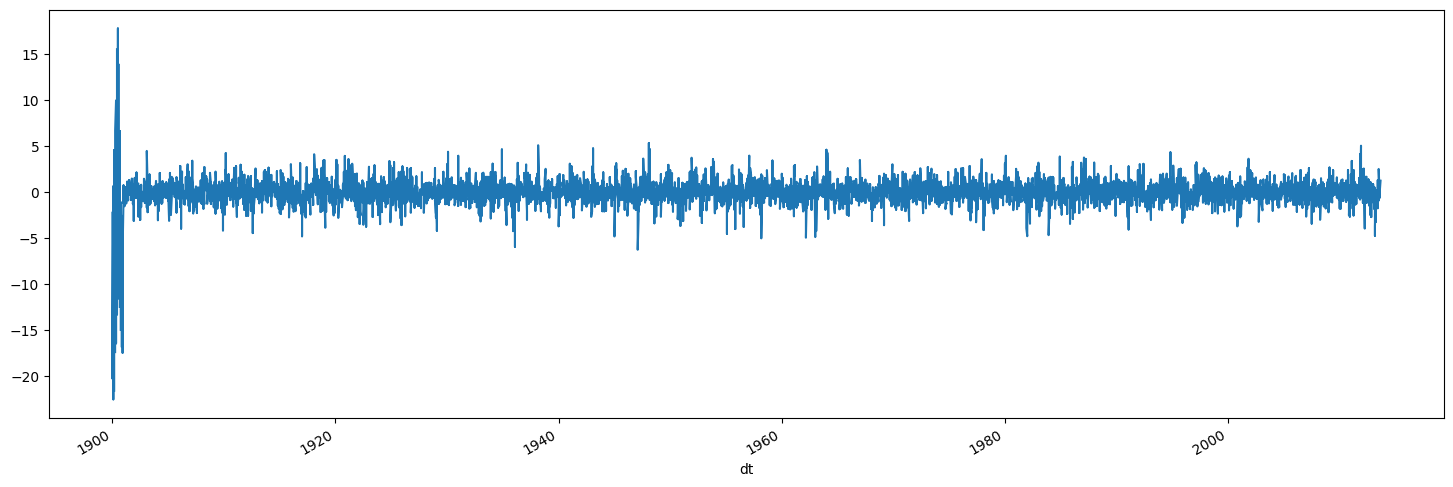

In [42]:
#plotting the stationary data

nation_temp_df['first_temp_diff'].plot(figsize=(18,6))
plt.show()

Now we don't have much variation as we did have earlier

In [43]:
#model building

#model data
model_df = nation_temp_df[['first_temp_diff']]

model_df.head()

,first_temp_diff
dt,
1900-01-01,NaN
1900-02-01,NaN
1900-03-01,NaN
1900-04-01,NaN
1900-05-01,NaN


In [44]:
#removing the null values

model_df.dropna(inplace=True)

#rechecking
model_df.head()

,first_temp_diff
dt,
1901-01-01,0.058
1901-02-01,0.182
1901-03-01,-0.626
1901-04-01,-0.257
1901-05-01,-0.578


In [45]:
#the pacf

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.graphics.api import qqplot

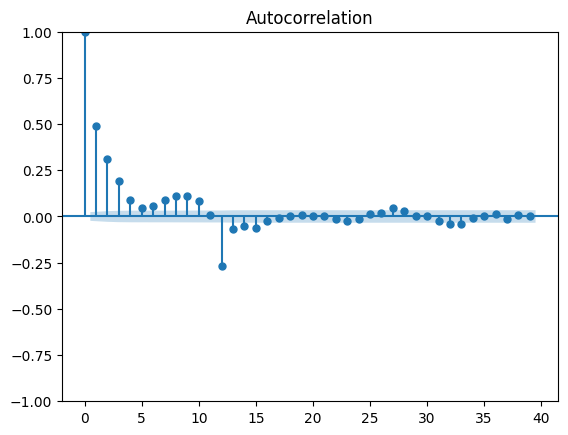

In [46]:
#plotting the acf

plot_acf(model_df['first_temp_diff'])
plt.show()

We select our q to be 3

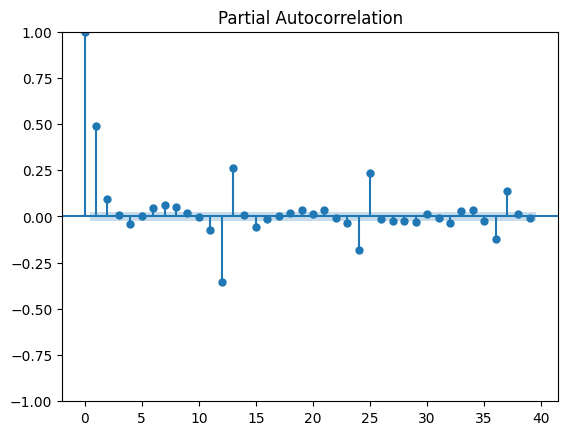

In [47]:
#plotting pacf

plot_pacf(model_df['first_temp_diff'])
plt.show()

Our p will be 2 from the viz above

In [48]:
#train and test

train = model_df[:'2010-12-31']
test = model_df['2011-01-01':]

In [49]:
#Applying ARIMA model

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from sklearn.metrics import mean_squared_error

In [50]:
arima =ARIMA(train,order=(2,1,3))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

In [51]:
#fitting the model

model_arima=arima.fit()

In [52]:
#forcasting

pred=model_arima.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [53]:
#Evaluating the model

rmse_arima=np.sqrt(mean_squared_error(test,pred))

rmse_arima

1.236798988818663

In [54]:
#Making the predictions

forecast =pred
forecast_index=test.index
forecast_series = pd.Series(forecast, index=forecast_index)

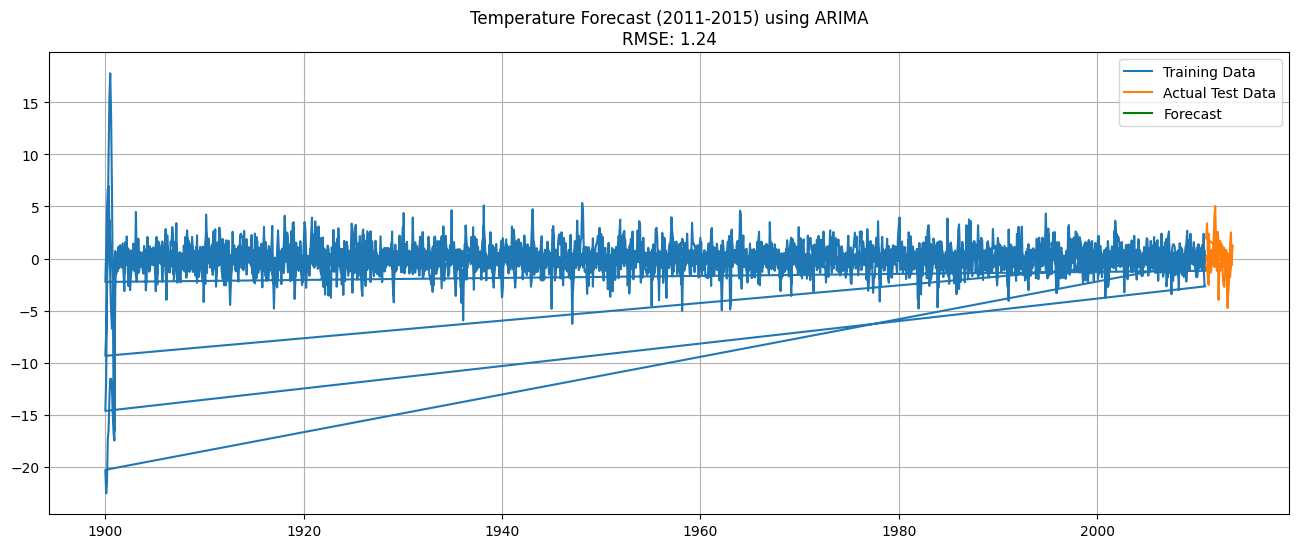

In [55]:
#visualizing the results

plt.figure(figsize=(16, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Test Data')
plt.plot(forecast_series, label='Forecast', color='green')
plt.title('Temperature Forecast (2011-2015) using ARIMA\nRMSE: {:.2f}'.format(rmse_arima))
plt.legend()
plt.grid(True)
plt.show()


To further improve accuracy, a deeper dive into parameter tuning for ARIMA, adding exogenous variables, or using more complex models like LSTM can be considered.